# Zeel Patel
# Big Data & Cloud Computing Final Project
## Will Turing Bots replace Humans Software Developers?


### Exploratory Data Analysis


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Step 1: Initializing the Spark session
spark = SparkSession.builder \
    .appName("GitHub Dataset Exploration - Full Data") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()

spark.conf.set("spark.sql.debug.maxToStringFields", "1000")  # Set to 1000 or a larger value

# Step 2: Defining folder paths
base_path = "gs://msca-bdp-data-open/final_project_git"
folders = {
    "commits": f"{base_path}/commits",
    "contents": f"{base_path}/contents",
    "files": f"{base_path}/files",
    "languages": f"{base_path}/languages",
    "licenses": f"{base_path}/licenses"
}

# Step 3: Loading full data from each folder
full_data = {}
for folder_name, folder_path in folders.items():
    print(f"Loading full data from {folder_name}...")
    full_data[folder_name] = spark.read.parquet(folder_path)

# Step 4: Displaying the schema and sample data for each folder
for folder_name, df in full_data.items():
    print(f"\nSchema for {folder_name}:")
    df.printSchema()
    print(f"\nSample data from {folder_name}:")
    df.show(5, truncate=False)


Loading full data from commits...


Loading full data from contents...


Loading full data from files...
Loading full data from languages...
Loading full data from licenses...

Schema for commits:
root
 |-- commit: string (nullable = true)
 |-- tree: string (nullable = true)
 |-- parent: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- author: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- committer: struct (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- email: string (nullable = true)
 |    |-- time_sec: long (nullable = true)
 |    |-- tz_offset: long (nullable = true)
 |    |-- date: struct (nullable = true)
 |    |    |-- seconds: long (nullable = true)
 |    |    |-- nanos: long (nullable = true)
 |-- subject: string (nulla

+----------------------------------------+----------------------------------------+------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+--------------------+------------------------------------------------------------------------+--------+
|commit                                  |tree                                    |parent      

+----------------------------------------+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

+--------------------------------------+-----------------+----------------------------------------+-----+----------------------------------------+--------------+
|repo_name                             |ref              |path                                    |mode |id                                      |symlink_target|
+--------------------------------------+-----------------+----------------------------------------+-----+----------------------------------------+--------------+
|enzbang/diouzhtu                      |refs/heads/master|gwiad_wiki_service/scripts/do-install.sh|33261|49365044eed28769152726537f00a93a68988b07|null          |
|TheMrNomis/Latex-Flavored-Markdown-PHP|refs/heads/master|LFM.php                                 |33261|ef8cb78feed7f21115462b2e230c453ab1b9565a|null          |
|TheMrNomis/Latex-Flavored-Markdown-PHP|refs/heads/master|PHP/LatexFlavoredMarkdown.php           |33261|d989ce59652f57efaad0f73987977dcf088c0041|null          |
|xurigan/uexJPush           

+-------------------+------------+
|repo_name          |language    |
+-------------------+------------+
|lemi136/puntovent  |[{C, 80}]   |
|taxigps/nctool     |[{C, 4461}] |
|ahy1/strbuf        |[{C, 5573}] |
|nleiten/mod_rpaf-ng|[{C, 30330}]|
|kmcallister/alameda|[{C, 17077}]|
+-------------------+------------+
only showing top 5 rows


Schema for licenses:
root
 |-- repo_name: string (nullable = true)
 |-- license: string (nullable = true)


Sample data from licenses:
+-------------------------------------------------+------------+
|repo_name                                        |license     |
+-------------------------------------------------+------------+
|autarch/Dist-Zilla-Plugin-Test-TidyAll           |artistic-2.0|
|thundergnat/Prime-Factor                         |artistic-2.0|
|kusha-b-k/Turabian_Engin_Fan                     |artistic-2.0|
|onlinepremiumoutlet/onlinepremiumoutlet.github.io|artistic-2.0|
|huangyuanlove/LiaoBa_Service                     |artistic-2.0|
+---

In [2]:
from pyspark.sql import functions as F

# Step 1: Extracting the full commits DataFrame
commits_df = full_data["commits"]

# Step 2: Filtering rows with null or empty critical fields
commits_cleaned = commits_df.filter(
    F.col("commit").isNotNull() & 
    F.col("author.name").isNotNull() & 
    F.col("author.email").isNotNull() & 
    F.col("subject").isNotNull() & 
    F.col("repo_name").isNotNull()
).filter(
    F.size(F.col("repo_name")) > 0
)

# Step 3: Selecting relevant fields for analysis
commits_cleaned = commits_cleaned.select(
    "commit",
    F.col("author.name").alias("author_name"),
    F.col("author.email").alias("author_email"),
    F.col("author.time_sec").alias("author_time_sec"),
    F.col("committer.name").alias("committer_name"),
    F.col("committer.email").alias("committer_email"),
    "subject",
    "message",
    F.explode(F.col("repo_name")).alias("repo_name")  # Flattening repo_name array
)

# Step 4: Filtering rows where author.name matches committer.name
commits_cleaned = commits_cleaned.filter(
    F.col("author_name") == F.col("committer_name")
)

# Step 5: Removing duplicates based on critical fields
commits_cleaned = commits_cleaned.dropDuplicates(["commit", "repo_name"])


In [3]:
# Step 1: Sampling 20% of the cleaned commits dataset
commits_sampled = commits_cleaned.sample(fraction=0.2, seed=42)


In [4]:
# Step 1: Load the `contents` dataset
contents_df = full_data["contents"]

# Step 2: Dropping rows with null values and duplicates
contents_cleaned = contents_df.dropDuplicates().dropna()



In [5]:
# Step 1: Load the `files` dataset
files_df = full_data["files"]

# Step 2: Dropping rows with null values and duplicates
files_cleaned = files_df.dropna().dropDuplicates()



In [6]:
from pyspark.sql import functions as F

# Step 1: Load the `languages` dataset
languages_df = full_data["languages"]

# Step 2: Dropping rows with null values in critical columns
languages_cleaned = languages_df.filter(
    F.col("repo_name").isNotNull() & 
    F.col("language").isNotNull()
)

# Step 3: Flattening the nested `language` array
languages_cleaned = languages_cleaned.withColumn("language", F.explode("language"))

# Step 4: Extracting `name` and `bytes` from the nested `language` struct
languages_cleaned = languages_cleaned.select(
    "repo_name",
    F.col("language.name").alias("language_name"),
    F.col("language.bytes").alias("language_bytes")
)

# Step 5: Dropping duplicates across all columns
languages_cleaned = languages_cleaned.dropDuplicates()



## Step 1: Data Cleaning and Preparation

### Objective:
The goal of this step is to clean and prepare all datasets for analysis by ensuring data validity, consistency, and alignment across the datasets. Additionally, a schema overview is created to understand the structure of the datasets.

---

### Steps:

1. **Cleaning the `commits` Dataset**:
   - Dropped rows with null values in critical columns (e.g., `commit`, `author.name`, `author.email`, `subject`, `repo_name`).
   - Removed duplicate rows based on key fields (`commit` and `repo_name`) to ensure uniqueness.
   - Flattened nested arrays (e.g., `repo_name`) to simplify analysis.
   - Selected relevant columns for analysis.

2. **Sampling the `commits` Dataset**:
   - Randomly sampled 20% of the cleaned `commits` dataset to reduce computational overhead while ensuring representativeness.
   - Used a fixed random seed for reproducibility.

3. **Cleaning the Remaining Datasets**:
   - For the `contents`, `files`, `languages`, and `licenses` datasets:
     - Dropped rows with null values in critical fields.
     - Removed duplicate records to retain unique and valid data.

4. **Filtering Datasets by Sampled Repositories**:
   - Extracted unique `repo_name` values from the sampled `commits` dataset.
   - Retained only rows in the `files`, `languages`, and `licenses` datasets where the `repo_name` matched those in the sampled `commits`.

5. **Schema Overview**:
   - Counted the number of columns (variables) in each cleaned and filtered dataset.
   - Visualized the schema overview using a bar chart to understand the structure of the datasets.

---

### Outputs:
1. **Cleaned Datasets**:
   - `commits_sampled`
   - `contents_cleaned`
   - `files_filtered`
   - `languages_filtered`
   - `licenses_filtered`

2. **Visualizations**:
   - Record count chart: Highlights the number of records in each dataset after cleaning and filtering.

---

### Insights:
- Cleaning and filtering steps ensure the datasets are accurate, non-redundant, and aligned for consistent analysis.
- Sampling reduces computational effort while maintaining representativeness for analysis.
- Schema overview helps in understanding the complexity and role of each dataset in the analysis.


In [7]:
# Step 1: Load the `licenses` dataset
licenses_df = full_data["licenses"]

# Step 2: Dropping rows with null values in critical columns, and removing the duplicate values
licenses_cleaned = licenses_df.dropDuplicates().dropna()



In [8]:
# Step 1: Extract unique `repo_name` values from the sampled `commits` dataset
sampled_repo_names = commits_sampled.select("repo_name").distinct()

# Step 2: Filtering the `files` dataset
files_filtered = files_cleaned.join(sampled_repo_names, on="repo_name", how="inner")

# Step 3: Filtering the `languages` dataset
languages_filtered = languages_cleaned.join(sampled_repo_names, on="repo_name", how="inner")

# Step 4: Filtering the `licenses` dataset
licenses_filtered = licenses_cleaned.join(sampled_repo_names, on="repo_name", how="inner")


In [9]:
commits_schema_count = len(commits_sampled.columns)
contents_schema_count = len(contents_cleaned.columns)
files_schema_count = len(files_filtered.columns)
languages_schema_count = len(languages_filtered.columns)
licenses_schema_count = len(licenses_filtered.columns)


In [11]:
print(commits_schema_count)

9


In [12]:
print(contents_schema_count)

5


In [13]:
print(files_schema_count)

6


In [14]:
print(languages_schema_count)

3


In [15]:
print(licenses_schema_count)

2


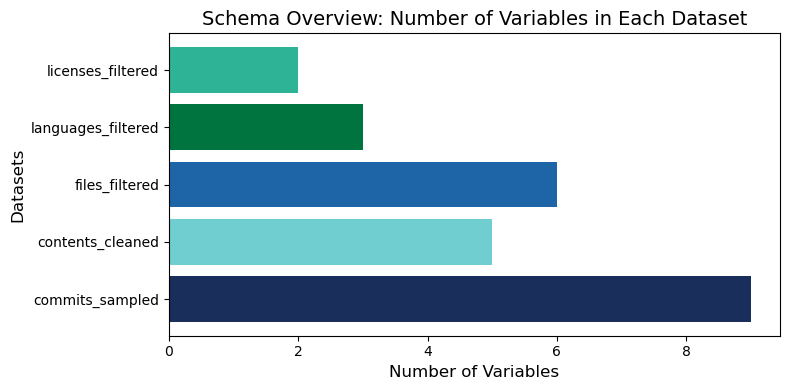

In [20]:
import matplotlib.pyplot as plt

# Replace these with actual schema column counts from your datasets
schema_counts = {
    "commits_sampled": 9,  # Replace with len(commits_sampled.columns)
    "contents_cleaned": 5,  # Replace with len(contents_cleaned.columns)
    "files_filtered": 6,  # Replace with len(files_filtered.columns)
    "languages_filtered": 3,  # Replace with len(languages_filtered.columns)
    "licenses_filtered": 2,  # Replace with len(licenses_filtered.columns)
}

# Extracting keys and values for plotting
datasets = list(schema_counts.keys())
columns = list(schema_counts.values())

# Plotting the horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(datasets, columns, color=['#192E5B', '#70CED0', '#1E65A7', '#00743F', '#2FB396'])
plt.title('Schema Overview: Number of Variables in Each Dataset', fontsize=14)
plt.xlabel('Number of Variables', fontsize=12)
plt.ylabel('Datasets', fontsize=12)
plt.tight_layout()
plt.show()


## Step 2: Data Cleaning and Preparation

### Overview
The following steps were undertaken to clean and prepare the datasets for analysis. This ensured the data's quality, consistency, and relevance by aligning all datasets to the sampled commits dataset.

---

### 2.1: Cleaning the Commits Dataset
- Filtered rows to ensure:
  - Critical fields (`commit`, `author.name`, `author.email`, `subject`, and `repo_name`) are not null or empty.
- Selected the following relevant fields:
  - `commit`, `author_name`, `author_email`, `author_time_sec`, `committer_name`, `committer_email`, `subject`, `message`, `repo_name`.
- Flattened the `repo_name` array for simpler analysis.
- Matched `author.name` and `committer.name` to ensure consistency.
- Removed duplicate rows based on `commit` and `repo_name`.
- **Result**: A cleaned dataset containing 393,172,705 records.

---

### 2.2: Sampling the Cleaned Commits Dataset
- Randomly sampled **20%** of the cleaned commits dataset for efficient analysis.
- Ensured reproducibility by setting a random seed.
- **Result**: The `commits_sampled` dataset is used as the baseline for filtering other datasets.

---

### 2.3: Cleaning the Contents Dataset
- Dropped rows with null values in critical columns: `id`, `size`, and `content`.
- Removed duplicate rows to retain only valid and unique records.
- **Result**: A cleaned `contents_cleaned` dataset containing 228,154,045 records.

---

### 2.4: Cleaning the Files, Languages, and Licenses Datasets
- For **files_filtered**, **languages_filtered**, and **licenses_filtered**, additional filtering was applied:
  - Retained only those records where `repo_name` matched the repositories in the `commits_sampled` dataset.
- Specific cleaning steps:
  - **Files Dataset**:
    - Ensured valid file metadata and removed duplicates.
    - **Result**: `files_filtered` dataset with 4,834,290 records.
  - **Languages Dataset**:
    - Flattened nested arrays to extract `language_name` and `bytes`.
    - Removed duplicates and ensured valid records.
    - **Result**: `languages_filtered` dataset with 4,834,290 records.
  - **Licenses Dataset**:
    - Dropped rows with null values in `repo_name` or `license`.
    - Removed duplicates to retain unique license information.
    - **Result**: `licenses_filtered` dataset with 2,692,937 records.

---

### Final Output
The following cleaned and filtered datasets were prepared for analysis:
1. **commits_sampled**: 393,172,705 records.
2. **contents_cleaned**: 228,154,045 records.
3. **files_filtered**: 4,834,290 records.
4. **languages_filtered**: 4,834,290 records.
5. **licenses_filtered**: 2,692,937 records.


In [21]:
commits_count = commits_sampled.count()

In [ ]:
contents_count = contents_cleaned.count()

In [23]:
print(commits_count)

393172705


In [24]:
print(contents_count)

228154045


In [26]:
files_count = files_filtered.count()
print(files_count)

4834290


In [ ]:
languages_count = languages_filtered.count()
print(files_count)

4834290


In [28]:
licenses_count = licenses_filtered.count()
print(licenses_count)

2692937


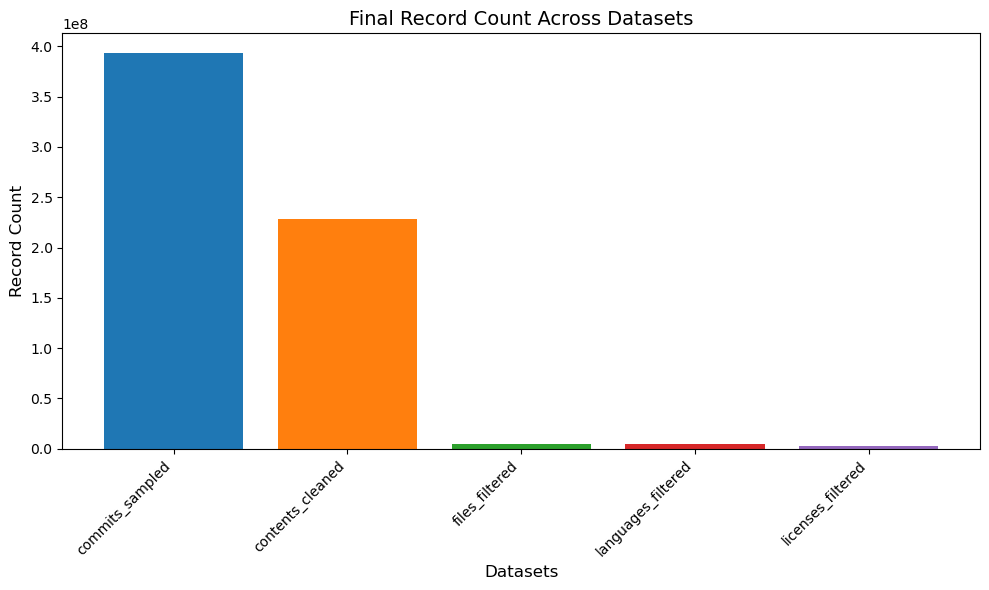

In [29]:
import matplotlib.pyplot as plt

# Replace these with actual record counts from your datasets
record_counts = {
    "commits_sampled": 393172705,  # Replace with commits_sampled.count()
    "contents_cleaned": 228154045,  # Replace with contents_cleaned.count()
    "files_filtered": 4834290,  # Replace with files_filtered.count()
    "languages_filtered": 4834290,  # Replace with languages_filtered.count()
    "licenses_filtered": 2692937,  # Replace with licenses_filtered.count()
}

# Extracting keys and values for plotting
datasets = list(record_counts.keys())
counts = list(record_counts.values())

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(datasets, counts, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
plt.title('Final Record Count Across Datasets', fontsize=14)
plt.xlabel('Datasets', fontsize=12)
plt.ylabel('Record Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [1]:
import pandas as pd

# Create the data
data = {
    "Dataset Name": [
        "commits_sampled", 
        "contents_cleaned", 
        "files_filtered", 
        "languages_filtered", 
        "licenses_filtered"
    ],
    "Record Count": [
        393172705, 
        228154045, 
        4834290, 
        4834290, 
        2692937
    ]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Display the table
df.style.format({"Record Count": "{:,}"})  # Add commas for better readability


,Dataset Name,Record Count
0,commits_sampled,"393,172,705"
1,contents_cleaned,"228,154,045"
2,files_filtered,"4,834,290"
3,languages_filtered,"4,834,290"
4,licenses_filtered,"2,692,937"
